# Diabetes Prediction (Binary Classification)

## Table of Contents

- [Introduction](#Introduction)
- [Data Overview  and Preparation](#Data-Overview-and-Preparation)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Training and Evaluation](#Model-Training-and-Evaluation)
- [Insights and Recommendations](#Insights-and-Recommendations)

## Introduction

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases, and for this specific project was pulled from [kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data). The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Dataset Overview
The dataset encompasses 8 predictor variables and the target variable `Outcome`:

* **Pregnancies**: Number of times pregnant
* **Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* **BloodPressure**: Diastolic blood pressure (mm Hg)
* **SkinThickness**: Triceps skin fold thickness (mm)
* **Insulin**: 2-Hour serum insulin (mu U/ml)
* **BMI**: Body mass index (weight in kg/(height in m)^2)
* **DiabetesPedigreeFunction**: Diabetes pedigree function (a function that scores the probability of diabetes based on family history, with a realistic range of 0.08 to 2.42; [source]( https://dergipark.org.tr/en/download/article-file/1970853#:~:text=The%20'DiabetesPedigreeFunction'%20is%20a%20function,1%20represents%20those%20with%20diabetes)
* **Age**: Age (years)
* **Outcome**: Class variable (0 or 1) 268 of 768 are 1, the others are 0

## Objective
The primary objective is to leverage this data to build a predictive model that predicts whether a patient has diabetes. Insights derived from this analysis will help healthcare professionals identify high-risk individuals and implement early interventions to manage and prevent diabetes. Additionally, this model can contribute to understanding the significant predictors of diabetes, aiding in better resource allocation and targeted awareness campaigns.

By developing a robust predictive model, we aim to:

* Improve diagnostic accuracy for diabetes in clinical settings.
* Identify key risk factors that contribute to the development of diabetes.
* Support the development of personalized treatment plans and preventive measures.
* Enhance overall public health strategies for diabetes management and prevention.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
)
from sklearn.inspection import permutation_importance

# Set display options for pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set display options for IPython
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set plot parameters
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 75

# Set seaborn style
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv('../data/diabetes.csv')

## Data Overview and Preparation

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* No missing values
* All features are numeric

In [5]:
df.duplicated().sum()

0

In [6]:
round(df.describe(), 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


`Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI` all have zero values that need to be investigated

## Data Cleaning

#### Visualizing the Distribution of Zero Values

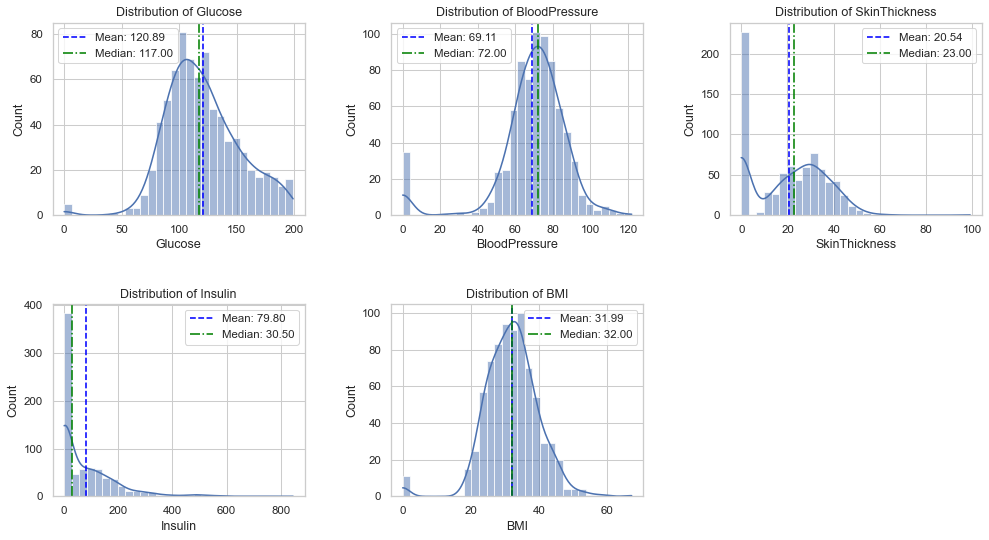

Number of zero values in each column:

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


In [7]:
# List of columns to check for zero values
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Plotting the distribution of zero values for each column
plt.figure(figsize=(14, 8))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    
    # Calculate mean and median
    mean_value = df[column].mean()
    median_value = df[column].median()
    
    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='blue', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='-.', label=f'Median: {median_value:.2f}')
    
    # Display the legend
    plt.legend()

plt.tight_layout(pad=3)
plt.show()

# Counting the number of zero values in each column
zero_counts = df[columns_to_check].apply(lambda x: (x == 0).sum())
print("Number of zero values in each column:\n")
print(zero_counts)

* `Glucose`, `BloodPressure`, `BMI` will be imputed with mean, as their distributions are Gaussian-like
* `SkinThickness`, `Insulin` will be imputed with median, as they both have outliers on the high end (right-skewed distributions with long tails)

In [8]:
mean_impute_columns = ['Glucose', 'BloodPressure', 'BMI']
median_impute_columns = ['SkinThickness', 'Insulin']

# Replace zero values with np.nan 
df[mean_impute_columns] = df[mean_impute_columns].replace(0, np.nan)
df[median_impute_columns] = df[median_impute_columns].replace(0, np.nan)

# Imputing with mean
mean_imputer = SimpleImputer(strategy='mean')
df[mean_impute_columns] = mean_imputer.fit_transform(df[mean_impute_columns])

# Imputing with median
median_imputer = SimpleImputer(strategy='median')
df[median_impute_columns] = median_imputer.fit_transform(df[median_impute_columns])

# Verify the imputation - check for zero values
df[columns_to_check].apply(lambda x: (x == 0).sum())

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [9]:
# Checking new minimum values to see if they're realistic
df[columns_to_check].apply(lambda x: x.min()).astype('int')

Glucose          44
BloodPressure    24
SkinThickness     7
Insulin          14
BMI              18
dtype: int32

`Glucose` 44 mg/dL is quite low and would be considered hypoglycemic. Normal fasting blood glucose levels typically range from about 70 to 99 mg/dL. While 44 mg/dL is not impossible, it is uncommon and would indicate severe hypoglycemia.

`BloodPressure` 
* **24mm Hg** is extremely low and not physiologically realistic for a diastolic blood pressure. Normal diastolic blood pressure ranges from 60 to 80 mm Hg.
* **DBP < 40 mm Hg**: Critically low and **potentially dangerous**. This can lead to inadequate perfusion of vital organs.
* Physiological Limits: In a clinical setting, diastolic pressures **as low as 30 or 38 mm Hg are sometimes seen in critically ill patients**, particularly those in intensive care units (ICUs). These patients typically require immediate medical intervention, including fluids, medications to support blood pressure (vasopressors), and close monitoring.


In [10]:
# Looking at all features for patients with severely low blood pressure (something to investigate in future iterations)
df[df['BloodPressure'] < 40]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
18,1,103.00,30.00,38.00,83.00,43.30,0.18,33,0
125,1,88.00,30.00,42.00,99.00,55.00,0.50,26,1
597,1,89.00,24.00,19.00,25.00,27.80,0.56,21,0
599,1,109.00,38.00,18.00,120.00,23.10,0.41,26,0


## Feature Engineering - *TBD*

## Exploratory Data Analysis

### Univariate Analysis

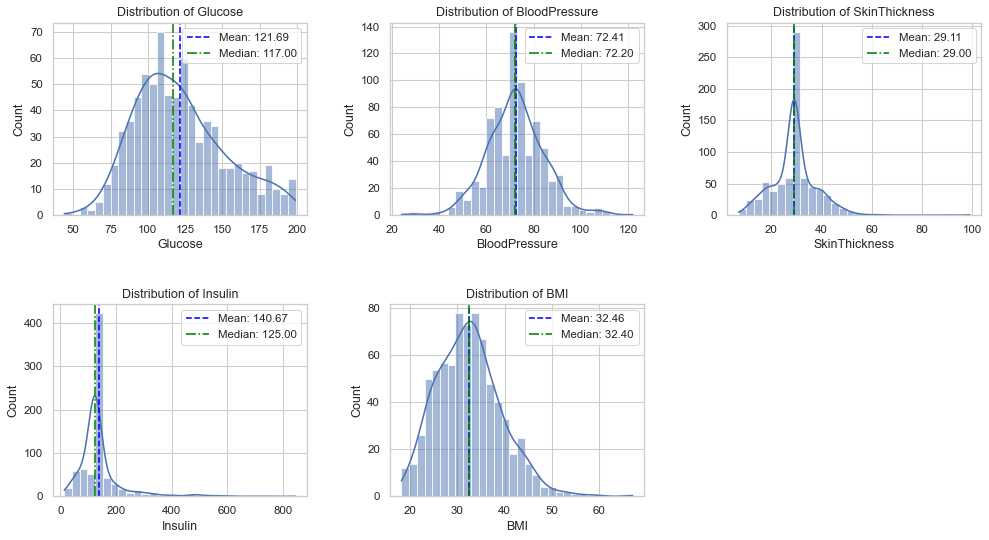

In [11]:
# Visualizing the distributions after imputations
plt.figure(figsize=(14, 8))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    
    # Calculate mean and median
    mean_value = df[column].mean()
    median_value = df[column].median()
    
    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='blue', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='-.', label=f'Median: {median_value:.2f}')
    
    # Display the legend
    plt.legend()

plt.tight_layout(pad=3)
plt.show()

The spikes for `SkinThickness` and `Insulin` have moved from zero to their median values

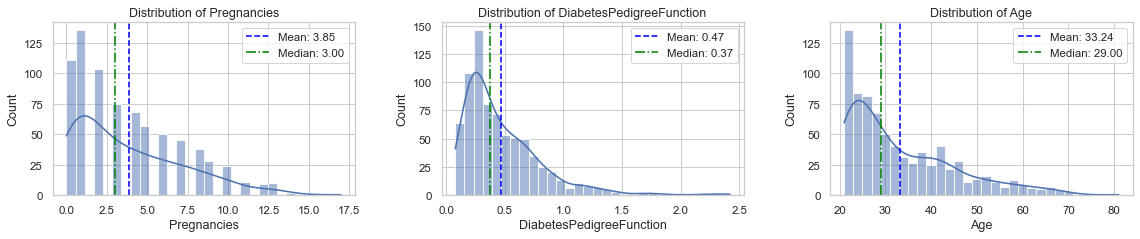

In [12]:
# Visualizing remaining columns that were not imputed
cols = ['Pregnancies', 'DiabetesPedigreeFunction', 'Age']

plt.figure(figsize=(16, 4))
for i, column in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    
    # Calculate mean and median
    mean_value = df[column].mean()
    median_value = df[column].median()
    
    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='blue', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='-.', label=f'Median: {median_value:.2f}')
    
    # Display the legend
    plt.legend()

plt.tight_layout(pad=3)
plt.show()

Variables are right-skewed
* Most number of `Pregnancies` are between 0 and 4
* `DiabetesPedigreeFunction` majority of values are clustered around 0.0 to 0.5
* `Age`: Half of the women are less than 30, while the remaining half are between about 30 and 80

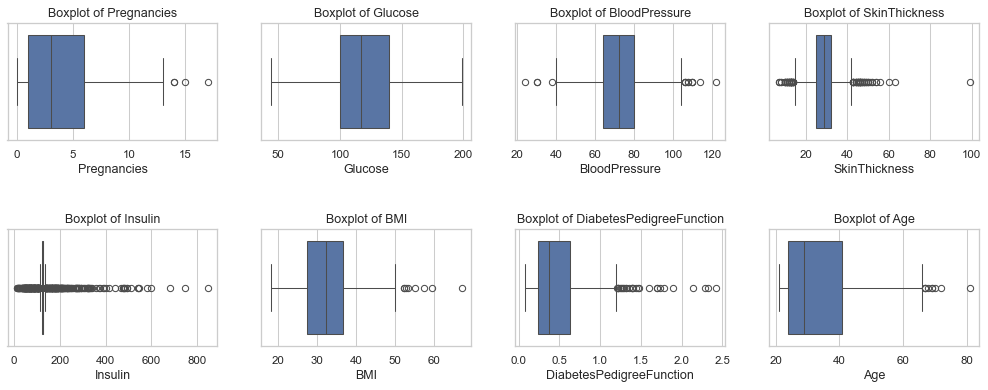

In [13]:
# List of features to plot
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

plt.figure(figsize=(14, 6))

# Plot each feature
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=feature, data=df, orient='h')
    plt.title(f'Boxplot of {feature}')

plt.tight_layout(pad=3)
plt.show()

Lots of outliers in Insulin and several in the last three variables, but nothing that needs to be treated

### Multivariate Analysis

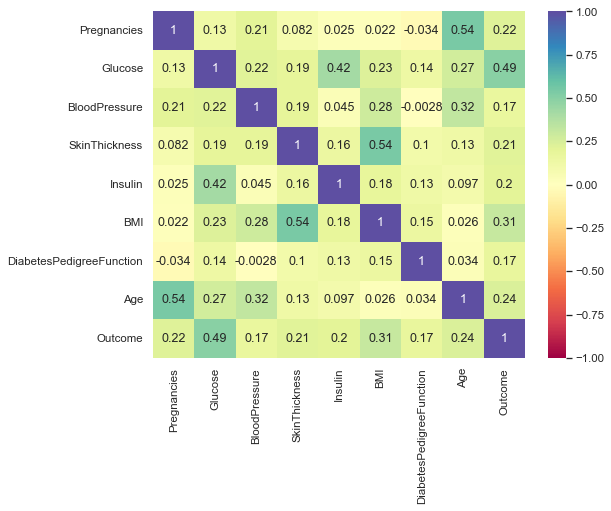

In [14]:
# Plotting a heatmap to quickly spot any high correlations
plt.figure(figsize=(8, 6))
sns.heatmap(data=df.corr(), annot=True, vmin=-1, vmax=1, cmap="Spectral")
plt.show()

No highly positive or highly negative correlations; only a few moderate correlations

In [15]:
# Summarizing any correlations over/under 0.5/-0.5
corr_matrix = df.corr()
threshold = 0.5
filtered_corr = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]
filtered_corr

# Remove self-correlations by setting diagonal to NaN
np.fill_diagonal(filtered_corr.values, np.nan)

# Drop rows and columns with all NaN values
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')
filtered_corr

,Pregnancies,SkinThickness,BMI,Age
Pregnancies,NaN,NaN,NaN,0.54
SkinThickness,NaN,NaN,0.54,NaN
BMI,NaN,0.54,NaN,NaN
Age,0.54,NaN,NaN,NaN


**Moderate associations**
* `Age` vs `Pregnancies`: makes sense, as women who are older would tend to have had more pregnancies
* `BMI` vs `SkinThickness`: both BMI and SkinThickness estimate body fat percentage, so the data makes sense that both variables move in the same direction

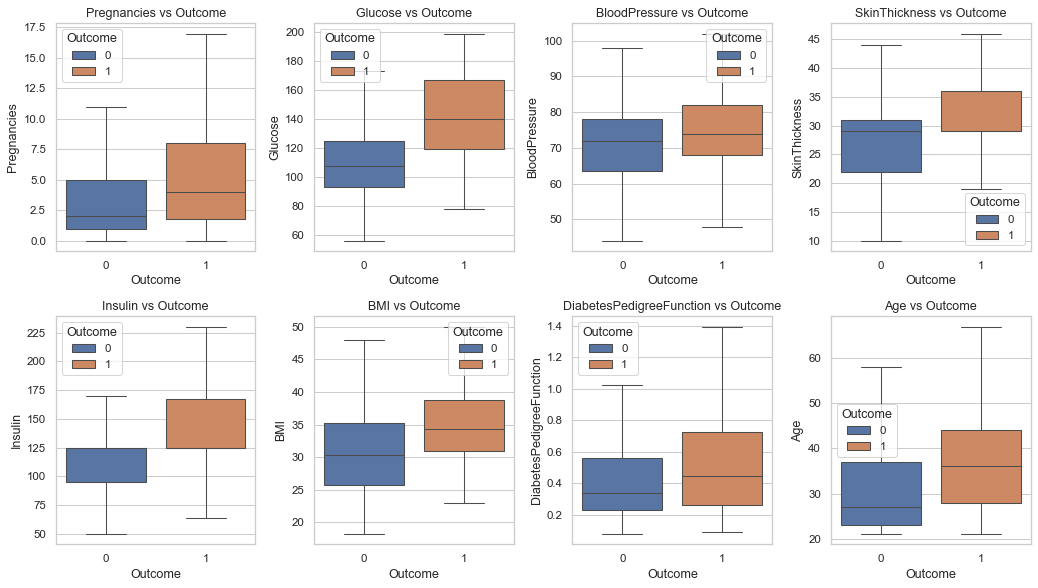

In [16]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Plot each feature against the target variable
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='Outcome', y=feature, data=df, hue='Outcome', showfliers=False)
    plt.title(f'{feature} vs Outcome')

plt.tight_layout()
plt.show()

All patients with diabetes (`Outcome` = 1) have higher values across every metric 

## Data Preprocessing

In [17]:
df.Outcome.value_counts(1)

Outcome
0   0.65
1   0.35
Name: proportion, dtype: float64

In [18]:
# Define features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns),
    ])

## Model Training and Evaluation

### Model evaluation criterion:

Model can make wrong predictions as:
1. Predicting a patient **will develop** diabetes and the patient does not - Loss of resources due to unnecessary treatment and patient anxiety.
    * This is a **false positive**.
    * The consequences include unnecessary medical tests, treatments, and patient stress or anxiety about a condition they do not have.
    * While it incurs costs and potential side effects, it ensures a conservative approach where more individuals are monitored.
<br>
<br>
2. Predicting a patient **will not develop** diabetes and the patient does - Loss of opportunity to identify patients at risk of developing diabetes and to intervene with preventative and early treatment efforts.
    * This is a **false negative**.
    * The consequences are more severe, including missed opportunities for early intervention, lifestyle changes, or treatments that could prevent or mitigate the severity of diabetes.
    * Patients may develop serious complications without timely medical attention.

**Which case is more important?**  
Scenario 2, reducing false negatives. Therefore, **Recall** should be maximized.  

Why Reducing False Negatives is Crucial:
* False negatives can lead to undiagnosed cases, delayed treatment, and higher long-term healthcare costs.
* Diabetes can lead to severe health issues such as cardiovascular diseases, nerve damage, kidney failure, and more. Early detection and management are critical to prevent these outcomes.

In [20]:
scorer = metrics.make_scorer(metrics.recall_score)

In [21]:
# Defining a function to compute different metrics
def model_performance_classification_sklearn(model, predictors, target):
    '''
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    '''

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            'Accuracy': acc,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
        },
        index=[0],
    )

    return df_perf

In [22]:
# Defining a function to create confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    '''
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    '''
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ['{0:0.0f}'.format(item) + '\n{0:.2%}'.format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Building Initial Models

In [23]:
models = []   # Empty list to store all the models

# Appending models into the list
models.append(('LR', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('SVM', SVC(random_state=42, class_weight='balanced')))
models.append(('RF', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')))
models.append(('GB', GradientBoostingClassifier(random_state=42)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
print('\nMean CV Recall on training dataset:' '\n')

# Evaluate using Stratified K-Folds and cross_val_score 
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    cv_result = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scorer) 
    results.append(cv_result)
    names.append(name)
    print(f'{name}: Mean CV Recall = {cv_result.mean():.3f} (± {cv_result.std() * 2:.3f})')


Mean CV Recall on training dataset:

LR: Mean CV Recall = 0.723 (± 0.162)
LDA: Mean CV Recall = 0.540 (± 0.195)
SVM: Mean CV Recall = 0.798 (± 0.126)
RF: Mean CV Recall = 0.625 (± 0.184)
GB: Mean CV Recall = 0.639 (± 0.138)


**SVM** has highest recall (79.8%), followed by **Logistic Regression** (72.3%)

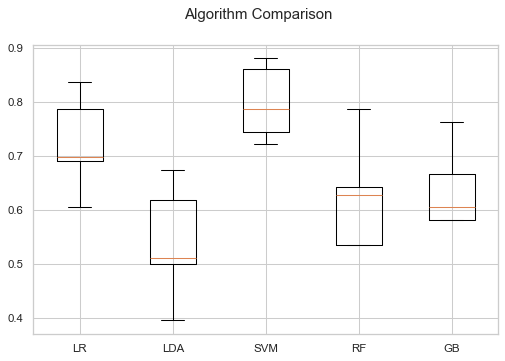

In [24]:
# Plot the results of each model's recall
fig = plt.figure(figsize=(8, 5))

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

## Hyperparameter Tuning

#### Tuning SVM

In [25]:
# SVM using randomized search
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, class_weight='balanced'))
])

random_search_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_grid_svm,
    n_iter=6,  # Reduced number of iterations
    scoring=scorer,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_svm.fit(X_train, y_train)

print('Best parameters are {} with CV score={}:' 
      .format(random_search_svm.best_params_, random_search_svm.best_score_)
)

Best parameters are {'classifier__kernel': 'rbf', 'classifier__C': 0.1} with CV score=0.8262458471760799:


In [26]:
# Tune SVM model 
svm_tuned = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=0.1, class_weight='balanced', random_state=42))
])

svm_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('classifier',
                 SVC(C=0.1, class_weight='balanced', random_state=42))])

In [27]:
# Calculate accuracy, recall, precision, and F1-score on the train set
svm_random_train = model_performance_classification_sklearn(
    svm_tuned, X_train, y_train
)
print('Training performance:')
svm_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.75,0.85,0.59,0.70


* Recall increased to 85% from 80%
* Accuracy and F1-score are moderately high, while Recall is high and Precision is moderate

In [28]:
# SVM pipeline configured with the best parameters
final_svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=0.1, class_weight='balanced', random_state=42))
])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(final_svm_model, X_train, y_train, cv=kfold, scoring=scorer)

print('Recall Scores per Fold: ', cv_scores)
print('Average Recall: {:.2f}'.format(cv_scores.mean()))
print('Recall Standard Deviation: {:.2f}'.format(cv_scores.std()))

Recall Scores per Fold:  [0.85714286 0.88372093 0.79069767 0.81395349 0.83333333]
Average Recall: 0.84
Recall Standard Deviation: 0.03


The average Recall of 0.84 and standard deviation of 0.03 across five folds suggests that the model is generalizing well

In [29]:
# Calculate accuracy, recall, precision, and F1-score on the test set
svm_random_test = model_performance_classification_sklearn(svm_tuned, X_test, y_test)
print('Test performance:')
svm_random_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.69,0.85,0.55,0.67


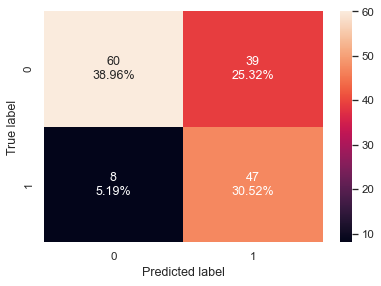

In [30]:
confusion_matrix_sklearn(svm_tuned, X_test, y_test)

SVM is performing well in all metrics on training and test sets. It is generalizing well, as the tuned model on testing data is identical in Recall compared to the tuned model on training data.

#### Tuning Logistic Regression

In [31]:
param_grid_lr = [
    {
        'classifier__C': np.logspace(-4, 4, 5),  # Regularization strength, fewer values for simplicity
        'classifier__penalty': ['l1', 'l2'],  # Penalty
        'classifier__solver': ['liblinear'],  # Solver
    },
    {
        'classifier__C': np.logspace(-4, 4, 5),  # Regularization strength, fewer values for simplicity
        'classifier__penalty': ['l2'],  # Penalty
        'classifier__solver': ['saga'],  # Solver
    },
    {
        'classifier__C': np.logspace(-4, 4, 5),  # Regularization strength, fewer values for simplicity
        'classifier__penalty': ['elasticnet'],  # Penalty
        'classifier__solver': ['saga'],  # Solver
        'classifier__l1_ratio': [0.25, 0.5, 0.75]  # For elasticnet penalty
    }
]

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

# Perform Randomized Search
random_search_lr = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=param_grid_lr,
    n_iter=10,  # Reduced number of parameter settings sampled
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search_lr.fit(X_train, y_train)

print('Best parameters are {} with CV score={}:'
      .format(random_search_lr.best_params_, random_search_lr.best_score_))

Best parameters are {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1.0} with CV score=0.5634551495016611:


In [32]:
lr_tuned = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga', penalty='l2', C=1.0, class_weight='balanced', random_state=42, max_iter=10000))
])

lr_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    random_state=42, solver='saga'))])

In [33]:
# Calculate accuracy, recall, precision, and F1-score on the train set
lr_random_train = model_performance_classification_sklearn(
    lr_tuned, X_train, y_train
)
print('Training performance:')
lr_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.76,0.73,0.63,0.68


* Recall increased to 73% from 72%
* Accuracy and Recall are moderately high, while Precision and F1-score are also moderate

In [34]:
# Logistic Regression pipeline configured with the best parameters
final_lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga', penalty='l2', C=1.0, class_weight='balanced', random_state=42, max_iter=10000))
])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(final_lr_model, X_train, y_train, cv=kfold, scoring=scorer)

print('Recall Scores per Fold: ', cv_scores)
print('Average Recall: {:.2f}'.format(cv_scores.mean()))
print('Recall Standard Deviation: {:.2f}'.format(cv_scores.std()))

Recall Scores per Fold:  [0.78571429 0.8372093  0.60465116 0.69767442 0.69047619]
Average Recall: 0.72
Recall Standard Deviation: 0.08


The average Recall of 0.72 and standard deviation of 0.08 across five folds suggest that the model has a consistent performance in identifying true positives, indicating it generalizes well. However, the variability in Recall scores indicates some inconsistency in performance across different folds.

In [35]:
# Calculate accuracy, recall, precision, and F1-score on the test set
lr_random_test = model_performance_classification_sklearn(lr_tuned, X_test, y_test)
print('Test performance:')
lr_random_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.71,0.71,0.57,0.63


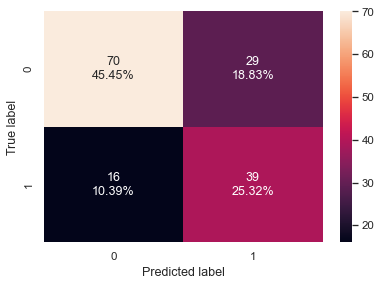

In [36]:
confusion_matrix_sklearn(lr_tuned, X_test, y_test)

Logistic Regression is performing well in all metrics on training and test sets. It is generalizing well, as the tuned model on testing data shows a recall that is only 2 percentage points lower than on the training data (73% vs. 71%).

## Model Performance Comparison and Final Model Selection

In [37]:
# Training performance comparison
models_train_comp_df = pd.concat(
    [
        svm_random_train.T,
        lr_random_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    'SVM tuned with random search',
    'Logistic Regression tuned with random search',
]
print('Training performance comparison:')
models_train_comp_df

Training performance comparison:


,SVM tuned with random search,Logistic Regression tuned with random search
Accuracy,0.75,0.76
Recall,0.85,0.73
Precision,0.59,0.63
F1,0.70,0.68


In [38]:
# Test performance comparison
models_test_comp_df = pd.concat(
    [
        svm_random_test.T,
        lr_random_test.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    'SVM tuned with random search',
    'Logistic Regression tuned with random search',
]
print('Test performance comparison:')
models_test_comp_df

Test performance comparison:


,SVM tuned with random search,Logistic Regression tuned with random search
Accuracy,0.69,0.71
Recall,0.85,0.71
Precision,0.55,0.57
F1,0.67,0.63


### Feature Importances

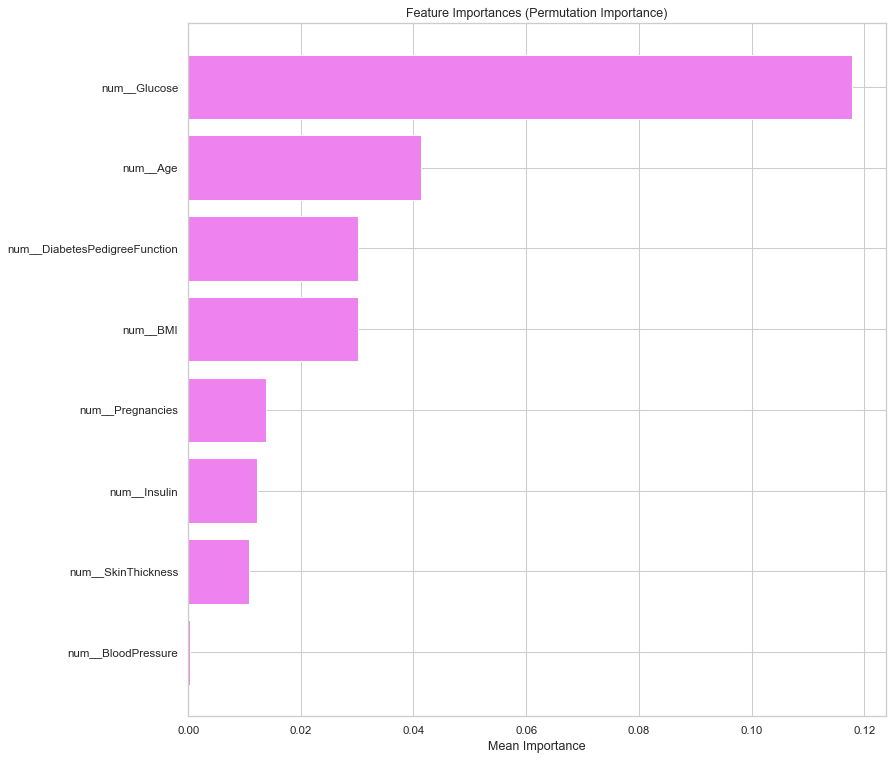

In [39]:
# Get feature names after preprocessing
feature_names = svm_tuned.named_steps['preprocessor'].get_feature_names_out()

# Perform permutation importance
result = permutation_importance(svm_tuned, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

# Extract importance and sort in descending order
sorted_indices = result.importances_mean.argsort()[::-1]
sorted_importances = result.importances_mean[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 12))
plt.title('Feature Importances (Permutation Importance)')
plt.barh(range(len(sorted_indices)), sorted_importances, color='violet', align='center')
plt.yticks(range(len(sorted_indices)), [sorted_feature_names[i] for i in range(len(sorted_indices))])
plt.xlabel('Mean Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

## Insights and Recommendations

### Insights (in order of importance)

1. `Glucose`: The feature importance is nearly 3x the next highest importance. Blood glucose levels are a significant predictor of diabetes, which aligns with medical knowledge, as blood glucose levels are a key indicator of diabetes. 

`Age`, `DiabetesPedigreeFunction`, and `BMI` feature importances are close, in positions 2, 3, and 4.

2. `Age`: Age is also a crucial factor in predicting diabetes. Older individuals are generally at a higher risk of developing diabetes.
3. `DiabetesPedigreeFunction`: As this feature measures the genetic likelihood of diabetes based on family history, its importance indicates that genetics play a significant role in the risk of diabetes.
4. `BMI`: highlighting the role of obesity in diabetes risk. Higher BMI values are often associated with an increased risk of developing diabetes.

`Pregnancies`, `Insulin`, and `SkinThickness` feature importances are close positions 5, 6, and 7.

5. `Pregnancies`: The number of pregnancies also plays a role, suggesting that women who have been pregnant multiple times may have a higher risk of diabetes, possibly due to gestational diabetes.
6, 7. `Insulin and SkinThickness`: These features have moderate importance, indicating their relevance in predicting diabetes, possibly through their relationship with insulin resistance and body fat distribution.
8. `BloodPressure`: Despite being the least important feature in your model, it's still noteworthy, especially considering the observations about patients with extremely low blood pressure values. Low blood pressure might not be a strong indicator in this dataset, but it could still provide valuable insights when combined with other features or additional data.

### Recommendations:

1. Further Investigation on Glucose Levels:
Since `Glucose` is the most important feature, ensure that glucose measurements are accurate and consistent. Consider focusing on improving the precision of glucose level measurements and possibly collecting more granular data.

2. `Age`-Related Interventions:
Develop age-specific interventions and screening programs, especially targeting older populations, to catch early signs of diabetes.

3. Family History Analysis:
Encourage the collection of detailed family medical histories to better understand the genetic predisposition captured by the `DiabetesPedigreeFunction` feature.

4. `BMI` Management Programs:
Implement weight management programs and promote healthy lifestyles to reduce BMI and, consequently, the risk of diabetes.

5. `Pregnancy` and Gestational Diabetes:
Focus on monitoring women who have had multiple pregnancies or who had gestational diabetes, as they are at higher risk of developing diabetes later in life.

6. Augmenting `BloodPressure` Data:
Consider finding additional data or conducting studies to investigate patients with critically low blood pressure. This could involve looking into other health records or integrating external datasets that provide more context to blood pressure readings.

[Back to TOC](#Table-of-Contents)